# Calibrating a 3D age-rotation relation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import george
from george.kernels import ExpSquaredKernel, WhiteKernel
import pandas as pd
import emcee
from MCMC_plots import make_plot
import time
import h5py
import os
from teff_bv import teff2bv
import barnes as bn

RESULTS_DIR = "results"
DATA_DIR = "data"

Load all data: clusters + astero

In [2]:
def load_data():
    
    # load clusters
    bv1, bv_err1, p, p_err, a, a_err, logg, logg_err, f = \
        np.genfromtxt(os.path.join(DATA_DIR, "clusters.txt")).T
    
    # load precise astero
    data = pd.read_csv(os.path.join(DATA_DIR, "vansaders.txt"))
    bv2 = teff2bv(data["Teff"], data["AMP_logg"], data["FeH"])
    bv_err2 = np.ones_like(bv2)*.1
    
    df = pd.read_csv(os.path.join(DATA_DIR, "chaplin_garcia.csv"))
    dfbvs = teff2bv(df["teff"], df["logg"], df["feh"])
    
    # load all other astero stars and concatenate
    age = np.concatenate((a, np.array(data["AMP_age"]), df["age"]))
    age_err = np.concatenate((a_err, np.array(data["AMP_age_err"]), .5*(df["age_errp"] + df["age_errm"])))
    period = np.concatenate((p, np.array(data["period"]), df["period"]))
    period_err = period * .1
    bv = np.concatenate((bv1, bv2, dfbvs))
    bv_err = np.concatenate((bv_err1, bv_err2, np.ones_like(dfbvs)*.1))
    logg = np.concatenate((np.ones_like(bv1)*4.4, data["AMP_logg"], df["logg"]))
    feh = np.concatenate((np.ones_like(bv1)*0., data["FeH"], df["feh"]))
    
    # remove very red stars
    m = (.4 < bv ) * (bv < 1.2) * (logg > 4.)
    #return age, age_err*2, bv, bv_err, period, period_err, logg, feh
    #age_err[age==4.568] = .1
    return age[m], age_err[m], bv[m], bv_err[m], period[m], period_err[m], logg[m], feh[m]

/Users/ruthangus/projects/fgkcupid/dev/teff_bv.py:16: RuntimeWarning: invalid value encountered in log10
  + d1*feh*np.log10(teff) + g1*logg + e1*logg*np.log10(teff)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in greater
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in less
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in greater
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:43: RuntimeWarning: invalid value encountered in less
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:56: RuntimeWarning: divide by zero encountered in log10
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in log10


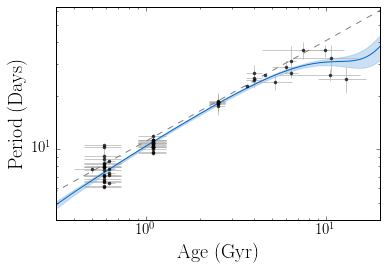

In [176]:
# plot model
def log_period_model(par, log_a, bv):
    return np.log10(par[0]) + par[1] * log_a + par[2] * np.log10(bv - par[3])

def load_original_data():
    # load data
    bv, bv_err, p, p_err, a, a_err, logg, logg_err, f = \
        np.genfromtxt("data/clusters.txt").T

    # load 16Cyg A
    bv16, bv_err16, p16, perr16, a16, aerr16, _, _, _, _ = \
        np.genfromtxt("data/16CygA.txt").T

    # load NGC6819
    bv19s, p19s = np.genfromtxt("data/NGC6819.txt", skip_header=1).T
    a19s = np.ones_like(p19s)*2.5
    
    # add M67 (rebecca + barnes)
    epic, bv67, v, p67, perr67 = np.genfromtxt("data/barnes_M67.txt", skip_header=1).T
    #epic, p67, bv67, bv_067, _ = np.genfromtxt("data/acf_ls_results.txt", skip_header=1,
    #                                     delimiter=",").T
    a67 = np.ones_like(p67) * 4
    
    # load astero
    data = np.genfromtxt("data/garcia_irfm.txt")
    p1, p_err1 = data[6], data[7]
    t1, t_err1 = data[1], data[2]
    a1, a_err1 = data[3], .5 * (data[4] + data[5])
    logg1, logg_err1 = data[8], .5 * (data[9] + data[10])
    feh1, feh_err1 = data[11], data[12]
    flag1 = data[13]
    bv1 = teff2bv(t1, logg1, feh1)
    m1 = logg1 > 4
    
    bv = np.concatenate((bv, bv16, bv19s, bv67, bv1[m1]))
    bv_err = np.concatenate((bv_err, bv_err16, np.ones_like(bv19s)*.01, np.ones_like(bv67)*.01, 
                            np.ones_like(bv1[m1])*.01))
    p = np.concatenate((p, p16, p19s, p67, p1[m1]))
    p_err = np.concatenate((p_err, perr16, p19s*.1, p67*.1, p_err1[m1]))
    a = np.concatenate((a, a16, a19s, a67, a1[m1]))
    a_err = np.concatenate((a_err, aerr16, a19s*.1, a67*.1, a_err1[m1]))
    
    # select based on colour
    m = (.6 < bv) * (bv < .7) * (p > 5) * (a/p < 1)
    ma = (.6 < bv1) * (bv1 < .7) * (logg1 > 4) * (a1/p1 < 1)
    
    pars = [.407, .566, .325, .495]  # MH
    xp = np.linspace(0, 20, 100)

    
    A, lbv, lp, sigma = 10, 2000, 10, 1.
    x, y, xerr, yerr = a[m], p[m], a_err[m], p_err[m]
    k = A**2 * ExpSquaredKernel(lp**2)
    gp = george.GP(k)
    gp.compute(x, (yerr**2+sigma**2)**.5)
    mus, covs = gp.predict(y-10**log_period_model(pars, np.log10(x*1000), .65), xp)
    vs = np.diag(covs)**.5
    mod = 10**log_period_model(pars, np.log10(xp*1000), .65)
    plt.plot(xp, mus+mod, color='#0066CC')
    plt.fill_between(xp, mus-vs+mod, mus+vs+mod, alpha=.2, color='#0066CC')

    plt.plot(xp, 10**log_period_model(pars, np.log10(xp*1000), .65), '.5', ls="--")
    plt.errorbar(a[m], p[m], xerr=a_err[m], yerr=p_err[m], fmt="k.", capsize=0, ecolor=".7", alpha=.7)
    #plt.errorbar(a1[ma], p1[ma], xerr=a_err1[ma], yerr=p_err1[ma], fmt="k.", capsize=0, ecolor=".7", alpha=.7)
    plt.xlim(10**-.5, 10**1.3)
    plt.ylim(10**.6, 10**1.8)
    plt.xlabel("$\mathrm{Age~(Gyr)}$")
    plt.ylabel("$\mathrm{Period~(Days)}$")
    plt.loglog()
    plt.subplots_adjust(left=.15, bottom=.16)
    plt.savefig("fgkcupid_demo.pdf")

load_original_data()


In [3]:
age, age_err, bv, bv_err, period, period_err, logg, feh = load_data()

/Users/ruthangus/projects/fgkcupid/dev/teff_bv.py:16: RuntimeWarning: invalid value encountered in log10
  + d1*feh*np.log10(teff) + g1*logg + e1*logg*np.log10(teff)
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in greater
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in less


Make 3D plot.

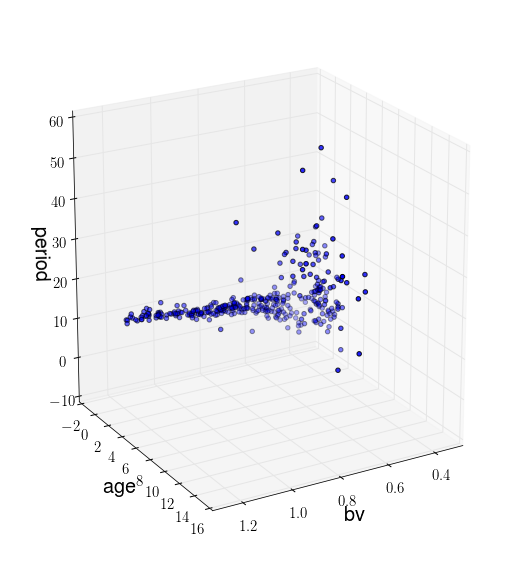

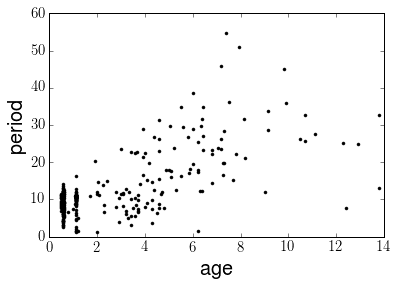

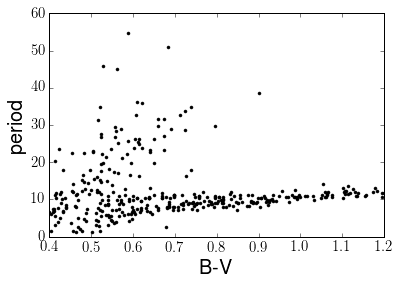

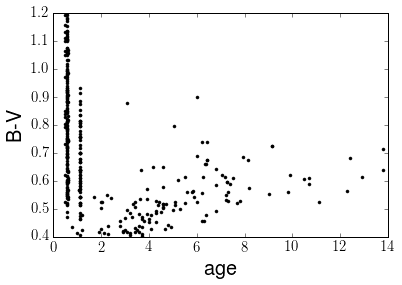

In [4]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(bv, age, period)
ax.set_xlabel("bv")
ax.set_ylabel("age")
ax.set_zlabel("period")
ax.view_init(20, 60)
plt.show()

plt.plot(age, period, "k.")
plt.xlabel("age")
plt.ylabel("period")
plt.show()

plt.plot(bv, period, "k.")
plt.xlabel("B-V")
plt.ylabel("period")
plt.show()

plt.plot(age, bv, "k.")
plt.xlabel("age")
plt.ylabel("B-V")
plt.show()

In [5]:
# set your x, y z and hyperparameters
D = np.vstack((bv, period)).T
A, lbv, lp, sigma = 10, 2000, 50, 1.

# GP prediction
k = A**2 * ExpSquaredKernel([lbv**2, lp**2], ndim=2)
gp = george.GP(k)
gp.compute(D, (age_err**2+sigma**2)**.5)

xs = np.zeros((1, 2))
xs[0, 0] = .65
xs[0, 1] = 26

mu, cov = gp.predict(age, xs)  # do the prediction
v = np.diag(cov)**.5
print(mu, "+/-", v)

[ 5.32544163] +/- [ 0.18666719]


Plot prediction for age vs period.

In [78]:
def plot_2d_prediction(x, y, xerr, yerr, mu, v, xs, theta, xlabel, ylabel):
    
    plotpar = {'axes.labelsize': 20,
           'font.size': 20,
           'legend.fontsize': 20,
           'xtick.labelsize': 15,
           'ytick.labelsize': 15,
           'text.usetex': True}
    plt.rcParams.update(plotpar)
    
    import barnes as bn
    ages = np.linspace(0, 20, 100)
    periods = bn.period(ages, .65)
    
    plt.plot(ages, periods)    
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt="k.", capsize=0, ecolor=".7")
    plt.errorbar(mu, xs, yerr=v, fmt=".", color='#FF33CC', ms=10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    xplot = np.linspace(min(x), max(x), 100)
    k = theta[0]**2 * ExpSquaredKernel(theta[1]**2)
    gp = george.GP(k)
    gp.compute(x, (yerr**2+sigma**2)**.5)
    mus, covs = gp.predict(y-bn.period(x, .65), xplot)  # do the prediction
    vs = np.diag(covs)**.5
    plt.plot(xplot, mus+bn.period(xplot, .65), color='#0066CC')
    #plt.ylim(0, 14)
    plt.fill_between(xplot, mus-vs, mus+vs, alpha=.2, color='#0066CC')
    plt.xlim(10**-.5, 10**1.3)
    plt.ylim(10**.6, 10**1.8)
    plt.loglog()
    plt.savefig("age_vs_period_demo")

[ 0.08802817  0.09674923  0.08549932  0.08085382  0.07309942  0.0827563
  0.09669013  0.09021155  0.05612048  0.0950602   0.08914962  0.0871757
  0.08347189  0.0729855   0.07436965  0.08384645  0.05751052  0.07759542
  0.07054236  0.07167073  0.07382222  0.0671102   0.07380811  0.06395029
  0.11506276  0.11434511  0.11055276  0.10752688  0.10710808  0.10710808
  0.1068999   0.10658915  0.10648596  0.10536398  0.10486177  0.10338346
  0.10232558  0.10232558  0.10166359  0.10138249  0.10009099  0.09892086
  0.09795191  0.09743136  0.09743136  0.09345794  0.06501951  0.20833333
  0.16123348  0.2031746   0.17508624  0.29705882  0.29396552  0.25646688
  0.21060606  0.33597561  0.24664032  0.27338403  0.1554902   0.21308725
  0.27715517  0.39984768  0.32882606  0.20746888  0.27576602  0.21857923
  0.51869723  0.23884403]


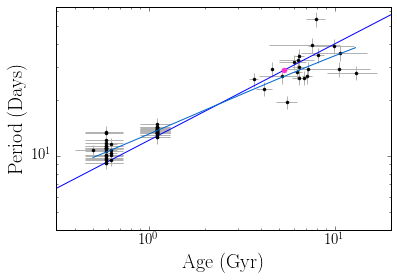

In [95]:
m = (.6 < bv) * (bv < .7) * (period > 5) * (age/period < 1)
print(age[m]/period[m])
#plot_2d_prediction(period[m], age[m], period_err[m], age_err[m], mu, v, xs[0, 1], 
#                   [A, lp, sigma], "$\mathrm{Period~(Days)}$", "$\mathrm{Age~(Gyr)}$")
plot_2d_prediction(age[m], period[m]+3, age_err[m], period_err[m], mu, v, xs[0, 1]+3, 
                   [A, lp, sigma], "$\mathrm{Age~(Gyr)}$", "$\mathrm{Period~(Days)}$")

Plot prediction for age vs color.

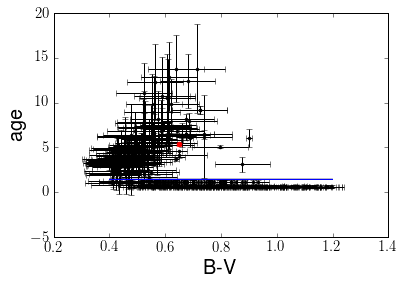

In [8]:
plot_2d_prediction(bv, age, bv_err, age_err, mu, v, xs[0, 0], [A, lbv, sigma], "B-V", "age")

Now perform MCMC.

Define the age model.

In [9]:
def gyro_age(pars, period, bv, barnes=False):
    """
    Calculates an age from a rotation period and colour.
    Parameters
    ----------
    pars: array or list
        gyrochronology parameters [a, b, n]
        barnes params are a, b, c, n = .7725, .601, .4, .5189
    period : array_like[nsamples]
        Rotation period in days.
    bv: array_like[nsamples]
        B-V color.
    Returns:
        Age in Gyr.
    """
    a, b, n = pars
    return (period / a * (bv - .4) ** b) ** n

Define initial parameters, prior, likelihood function and log prob.

In [10]:
theta_init = np.log(np.array([A, lbv, lp, sigma]))  # initial guess

In [11]:
def lnprior(theta):  # very broad uniform log prior
    if -20 < theta[0] < 20 and 0 < theta[1] < 20 and 0 < theta[2] < 20 and -20 < theta[3] < 20:
        return 0.
    return -np.inf

In [12]:
def lnlike(theta, x, y, z, yerr, mean_model=True):
    theta = np.exp(theta)
    D = np.vstack((x, z)).T
    k = theta[0]**2 * ExpSquaredKernel([theta[1]**2, theta[2]**2], ndim=2)
    gp = george.GP(k)
    try:
        gp.compute(D, (yerr**2 + theta[3]**2)**.5)
    except (ValueError, np.linalg.LinAlgError):
        return 10e25
    if mean_model:
        r = y - bn.age(z, x)
        m = np.isfinite(r)
        if len(r) > len(r[m]):
            return -np.inf
        return gp.lnlikelihood(r, quiet=True)
    return gp.lnlikelihood(y, quiet=True)

In [13]:
def lnprob(theta, x, y, z, yerr):
    return lnlike(theta, x, y, z, yerr) + lnprior(theta)

Set up MCMC.

In [14]:
x, y, z, yerr = bv, age, period, age_err
burnin, nwalkers, ndim = 1000, 24, len(theta_init)
runs = np.zeros(5) + 1000
p0 = [theta_init+1e-4*np.random.rand(ndim) for i in range(nwalkers)]
args = (x, y, z, yerr)

Time the lhf call.

In [15]:
start = time.time()
print("lnprob = ", lnprob(theta_init, x, y, z, yerr))
end = time.time()
tm = end - start
print("1 lhf call takes ", tm, "seconds")
print("burn in will take", tm * nwalkers * burnin, "s")
print("each run will take", tm * nwalkers * sum(runs)/60, "mins")
print("total = ", (tm * nwalkers * sum(runs) + tm * nwalkers * burnin)/60, "mins")

lnprob =  -796.02894204
1 lhf call takes  0.006000041961669922 seconds
burn in will take 144.00100708007812 s
each run will take 12.0000839233 mins
total =  14.400100708 mins


Run the MCMC.

burning in..., 1000 steps


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


production run, 1000 steps
time taken =  1.7715052326520284 minutes

 0.347678045339 period (days) 

[ 4.03632627  0.03707707  3.119962   -1.05647838]
Plotting traces


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Making triangle plot
plotting prediction
production run, 1000 steps
time taken =  1.786613682905833 minutes

 0.346388783008 period (days) 

[ 4.07279182  0.03415551  3.11630231 -1.06019348]
Plotting traces


/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Making triangle plot
plotting prediction
production run, 1000 steps
time taken =  1.7704521656036376 minutes

 0.348101367359 period (days) 

[ 4.06131287  0.03493991  3.1092087  -1.05526156]
Plotting traces
Making triangle plot
plotting prediction
production run, 1000 steps
time taken =  1.8468928019205728 minutes

 0.347659043165 period (days) 

[ 4.07028335  0.0365358   3.10683733 -1.05653304]
Plotting traces
Making triangle plot
plotting prediction
production run, 1000 steps
time taken =  1.8825793345769246 minutes

 0.348319148205 period (days) 

[ 4.07126317  0.03653796  3.10828946 -1.05463613]
Plotting traces
Making triangle plot
plotting prediction


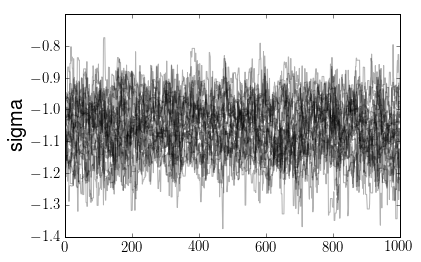

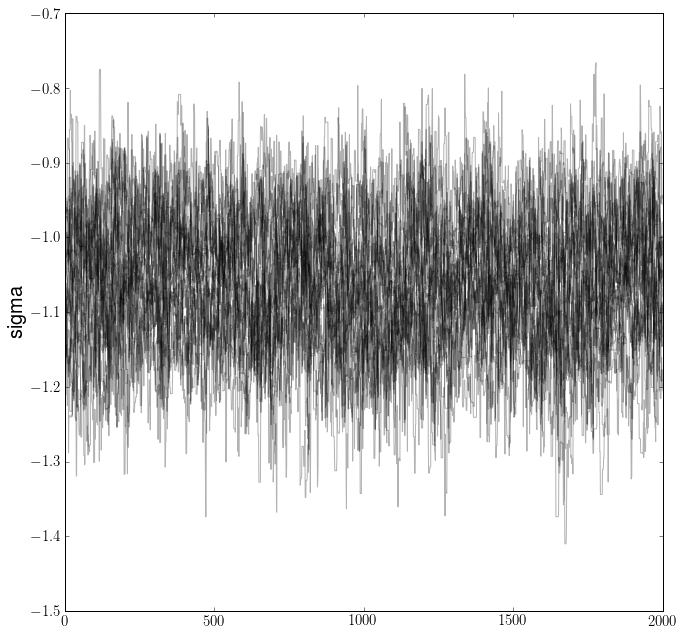

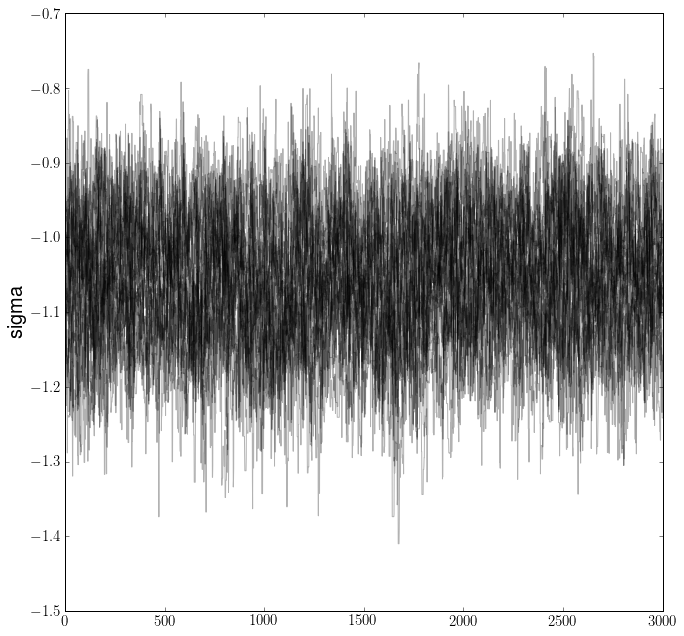

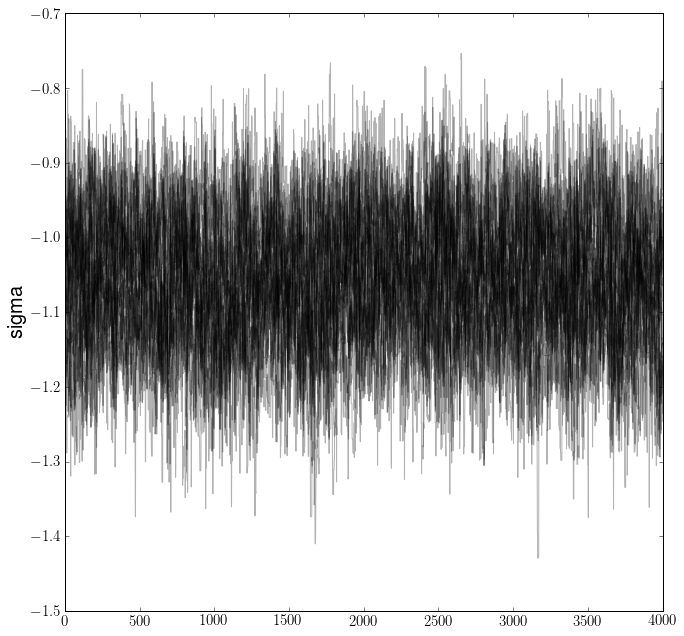

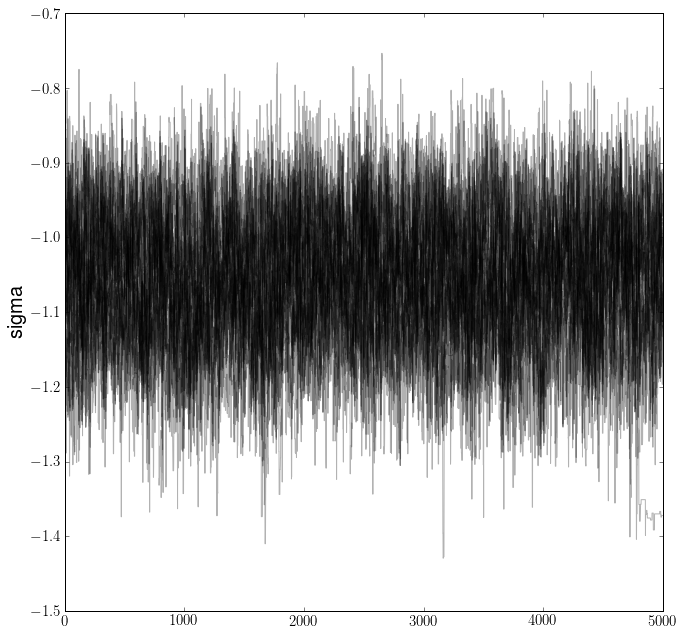

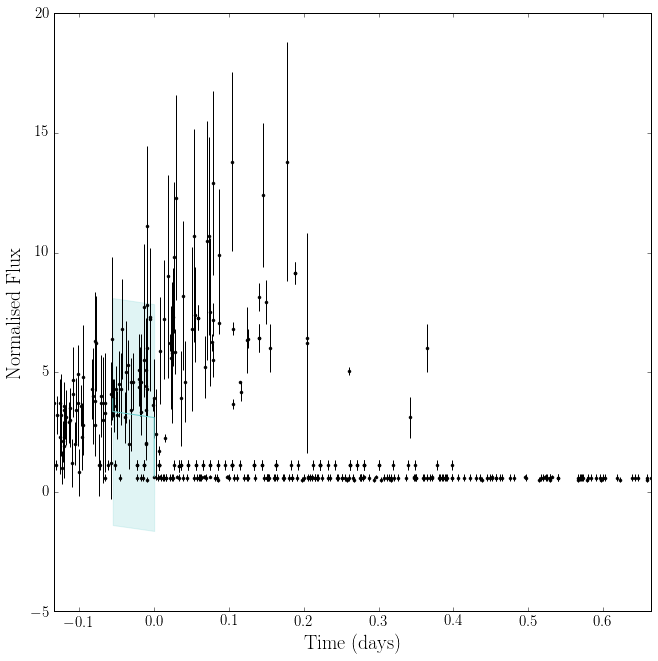

In [16]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
print("burning in..., {0} steps".format(int(burnin)))
p0, _, state = sampler.run_mcmc(p0, burnin)
fig_labels = ["A", "lbv", "lp", "sigma"]

sample_array = np.zeros((nwalkers, sum(runs), ndim))
for i, run in enumerate(runs):
    sampler.reset()
    print("production run, {0} steps".format(int(run)))
    start = time.time()
    p0, _, state = sampler.run_mcmc(p0, run)
    end = time.time()
    print("time taken = ", (end - start)/60, "minutes")
    
    # save samples
    sample_array[:, sum(runs[:i]):sum(runs[:(i+1)]), :] = np.array(sampler.chain)
    f = h5py.File(os.path.join(RESULTS_DIR, "3Dsamples.h5"), "w")
    data = f.create_dataset("samples", np.shape(sample_array))
    data[:, :] = sample_array
    f.close()
    
    # make plots at increments
    mcmc_result = make_plot(sample_array[:, :sum(runs[:(i+1)]), :], x, y, yerr, fig_labels, "3D", 
                            RESULTS_DIR, traces=True, tri=True, prediction=True)

Calculate the age of the Sun.

In [19]:
def age_model(mybv, myperiod, plot=False, barnes=True):
    """
    Given a rotation period and a colour, calculate the age.
    """
    
    # load the data for conditioning...
    age, age_err, bv, bv_err, period, period_err, logg, feh = load_data()
    
    # load the results
    with h5py.File(os.path.join(RESULTS_DIR, "3Dsamples.h5"), "r") as f:
            samples = f["samples"][...]
    nwalkers, nsteps, ndims = np.shape(samples)
    flat = np.reshape(samples, (nwalkers * nsteps, ndims))
    mcmc_result = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                      zip(*np.percentile(flat, [16, 50, 84], axis=0)))
    theta = np.exp(np.array([i[0] for i in mcmc_result]))

    A, lbv, lp, sigma = theta
        
    D = np.vstack((bv, period)).T
    k = A**2 * ExpSquaredKernel([lbv**2, lp**2], ndim=2)
    gp = george.GP(k)
    gp.compute(D, (age_err**2 + sigma**2)**.5)
    xs = np.zeros((1, 2))
    xs[0, 0] = mybv
    xs[0, 1] = myperiod
    mu, cov = gp.predict(age-bn.age(period, bv), xs)  # do the GP prediction
    #mu, cov = gp.predict(age, xs)  # do the GP prediction
    v = np.diag(cov)**.5
    mu += bn.age(myperiod, mybv)
    
    if plot:
        
        m = (myperiod - 10 < period) * (period < myperiod + 10)
        plt.errorbar(bv[m], age[m], xerr=bv_err[m], yerr=age_err[m], fmt="k.")
        plt.errorbar(mybv, mu, yerr=v, fmt="r.", ms=10)
        plt.xlabel("B-V")
        plt.ylabel("age")        
        xplot = np.linspace(min(bv[m]), max(bv[m]), 100)
        k = A**2 * ExpSquaredKernel(lbv**2)
        gp = george.GP(k)
        
        # Compute the prediction conditioned on the observations and plot it.
        gp.compute(bv[m], (age_err[m]**2 + sigma**2)**.5)
        #mus, covs = gp.predict(age[m], xplot)  # do the prediction
        mus, covs = gp.predict(age[m] - bn.age(myperiod, bv[m]), xplot)  # do the prediction
        vs = np.diag(covs)**.5
        plt.plot(xplot, mus + bn.age(myperiod, xplot), label=("period = {0}".format(myperiod)))
        plt.fill_between(xplot, mus + bn.age(myperiod, xplot) - vs - sigma,
                         mus + bn.age(myperiod, xplot) + vs + sigma, alpha=.2)
        #plt.plot(xplot, mus, label=("period = {0}".format(myperiod)))
        #plt.fill_between(xplot, mus - vs - sigma, mus + vs + sigma, alpha=.2)
        plt.legend(loc="best")
        plt.show()

        m = (mybv - .1 < bv) * (bv < mybv + .1)
        plt.errorbar(period[m], age[m], xerr=period_err[m], yerr=age_err[m], fmt="k.")
        plt.errorbar(myperiod, mu, yerr=v, fmt="r.", ms=10)
        plt.xlabel("period")
        plt.ylabel("age")
        xplot = np.linspace(min(period[m]), max(period[m]), 100)
        k = A**2 * ExpSquaredKernel(lp**2)
        gp = george.GP(k)
        gp.compute(period[m], (age_err[m]**2 + sigma**2)**.5)
        mus, covs = gp.predict(age[m] - bn.age(period[m], mybv), xplot)  # do the prediction
        #mus, covs = gp.predict(age[m], xplot)  # do the prediction
        vs = np.diag(covs)**.5
        #plt.plot(xplot, mus, label=("B-V = {0}".format(mybv)))
        #plt.fill_between(xplot, mus - vs - sigma, mus + vs + sigma, alpha=.2)
        plt.plot(xplot, mus + bn.age(xplot, mybv), label=("B-V = {0}".format(mybv)))
        plt.fill_between(xplot, mus + bn.age(xplot, mybv) - vs - sigma,
                         mus + bn.age(xplot, mybv) + vs + sigma, alpha=.2)
        plt.legend(loc="best")
        plt.show()
    
    print(theta)
    print("Age = {0} +/- {1} Gyr".format(mu[0], v[0]+theta[3]))
    return mu, v

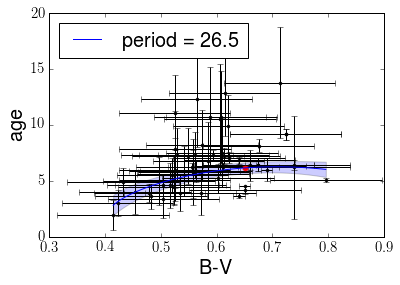

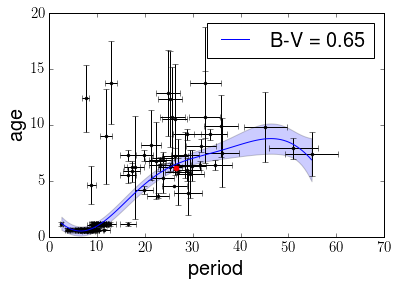

[ 60.14376994   1.04647051  22.55087071   0.3524333 ]
Age = 6.175388536480005 +/- 0.5037289791124363 Gyr


In [20]:
age = age_model(.65, 26.5, plot=True)

In [18]:
print(theta)

NameError: name 'theta' is not defined